## Импорты

In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

# from user_agents import parse

import datetime

from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn import tree

from sklearn import grid_search
from sklearn.tree import _tree

from sklearn.tree import export_graphviz

%pylab inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Объявления полезных функций

In [2]:
def log_mes(mes):
    """Выводит таймстемп и переданное сообщение"""
    print(datetime.datetime.now().strftime("%H:%M:%S %d.%m.%Y"), mes)

In [74]:
def plot_roc_curve(y, y_pred, color, name):
    fpr_moscow, tpr_moscow, _ = roc_curve(y, y_pred[:, 1])
    roc_auc = roc_auc_score(y, y_pred[:, 1])
    plt.plot(fpr_moscow, tpr_moscow, color=color, lw=2, label='{0} (AUC = {1:0.4f})'.format(name, roc_auc))

    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.xticks(arange(6)/5)
    plt.yticks(arange(6)/5)
    plt.grid(linestyle='-')
    
    plt.xlabel('False positive')
    plt.ylabel('True positive')
    plt.legend(loc=4, prop={'size': 20})

In [80]:
def plot_precision_recall(fig, y_test, y_pred, title, i, n):
    subplot = fig.add_subplot(n,1,i)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
    plt.step(recall, precision, color='blue', lw=1)
    plt.fill_between(recall, precision, step='pre', alpha=0.2, color='blue')
    plt.ylim([0, 1])
    plt.xlim([0, 1])

    subplot.yaxis.grid()
    subplot.xaxis.grid()
    subplot.set_xticklabels([])
    subplot.set_title(title)

## 1. Чтение выгрузки

In [3]:
metabase_unload = pd.read_csv('unloads/unload.csv', delimiter=",")

In [4]:
# Юзер-агент пока не использую, т.к. он очень долго анализируется
# metabase_unload['device'] = metabase_unload.apply(lambda x: parse(x['user_agent']).device if pd.isnull(x['user_agent']) == False else "None", axis=1)
# metabase_unload['os_version'] = metabase_unload.apply(lambda x: parse(x['user_agent']).os.version if pd.isnull(x['user_agent']) == False else "None", axis=1)
metabase_unload = metabase_unload.drop('user_agent', axis=1)

In [5]:
metabase_unload.where((metabase_unload["has_phone"] == False), axis = 1).dropna().size

22857

In [6]:
metabase_unload = metabase_unload.drop(["is_moscow_school", "school_id"], axis=1)

In [7]:
metabase_unload.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 17 columns):
user_id                           1048576 non-null int64
has_paid                          1048576 non-null int64
reg_page                          983876 non-null object
reason                            107570 non-null float64
teacher                           107570 non-null float64
time                              107570 non-null float64
best_statement                    107570 non-null float64
signed_up_on_weekend_day          1048576 non-null int64
signed_up_at_night_interval       1048576 non-null int64
source_group_id                   1048576 non-null int64
grade_id                          1048576 non-null int64
has_birth_date                    1048576 non-null int64
is_parent                         1048576 non-null int64
has_phone                         1048576 non-null int64
phone_confirmed                   1048576 non-null int64
address_entered_before_payme

## 2. Создание модели

In [94]:
class Model:
    def __init__(self):
        self._init_values()
        
        
    def fit(self, X_train, y_train):
        """
        1. Counts woe's 
        2. Binarieses category columns
        3. Fits XGBoost classifier
        """
        self._model_has_been_fit = False
        self._init_values()
        self._X_train = X_train
        self._y_train = y_train
        self._count_all_woe()
        self._create_and_fit_model()
        self._model_has_been_fit = True
        return self
        
    def predict_proba(self, X_test):
        """
        Predicts probability of 'has_paid' column
        """
        if not self._model_has_been_fit:
            raise RuntimeError("Model has not been fit. Prediction is impossible.")
            
        self._X_test = X_test
        return self._predict_proba()
        
    def plot_importance(self):
        """
        Plots XGBoost feature importance
        """
        if not self._model_has_been_fit:
            raise RuntimeError("Model has not been fit. Plotting is impossible.")

            fig = plt.figure(figsize=(15, 10))
        xgb.plot_importance(booster=self._model)    
    
    def get_tree(self, depht):
        """
        Fits decision tree classifier and returns graphviz tree in text
        """
        if not self._model_has_been_fit:
            raise RuntimeError("Model has not been fit. Drawing tree is impossible.")

        tree_clf = DecisionTreeClassifier(max_depth=depht)
        tree_clf.fit(self._X_train, self._y_train)
        return (export_graphviz(tree_clf, out_file=None, filled=True, feature_names=list(self._X_train.columns)))
    
    def _init_values(self):
        self._woe_dataframes = {}
        self._model_has_been_fit = False
    
    def _create_and_fit_model(self):
        self._X_train = self._transform_dataframe(self._X_train)

        # Модель
        self._model = xgb.XGBClassifier()
        self._model.fit(self._X_train, self._y_train)
        
    def _predict_proba(self):
        self._X_test = self._transform_dataframe(self._X_test)

        return self._model.predict_proba(self._X_test)

    def _count_all_woe(self):
        # Считаем woe-колонки
        woe_columns = ['source_group_id', 'region_id', 'reg_page', 'reason', 'teacher', 'time', 'best_statement']
        for column in woe_columns:
            self._count_woe(column)
    
    def _transform_dataframe(self, X):
        X = self._join_woe(X)
        X = self._drop_user_and_target(X)
        X = self._binarize_category_cols(X)
        return X

    def _drop_user_and_target(self, X):
        return X.drop(['has_paid', 'user_id'], axis = 1)
    
    def _binarize_category_cols(self, X):
        category_cols = ['grade_id']
        return pd.get_dummies(X, columns=category_cols, drop_first=True)
        
    def _count_woe(self, column_name):
        """
        Counts woe for passed column name in train dataset.
        Result stores in self._woe_dataframes
        """
        threshold = 100

        # расчет общего количества положительных и отрицательных событий
        paid_size = len(self._X_train[self._X_train['has_paid'] == 1])
        not_paid_size = len(self._X_train[self._X_train['has_paid'] == 0])

        # имя колонки, в которую будет помещен результат расчета
        woe_column_name = column_name + '_woe'

        # расчет общего количества пользователей и количества положительных событий для каждой категории
        woe_ds = self._X_train\
            .groupby([column_name])\
            .agg({'user_id':'size', 'has_paid':'sum'})\
            .reset_index()\
            .rename(columns={'user_id':'total'})

        # отсекаем категории, в которых количество пользователей не превышает 100 и категории, 
        # в которых нет ни одного положительного события
        woe_ds = woe_ds[(woe_ds['total'] > threshold) & (woe_ds['has_paid'] > 0)]

        # расчитываем количество отрицательных событий для каждой из категорий
        woe_ds['has_not_paid'] = woe_ds.apply(lambda x: x.total - x.has_paid, axis=1)

        # рассчитываем WOE
        woe_ds["woe_value"] = woe_ds\
            .apply(lambda x: math.log((x.has_paid/paid_size)/(x.has_not_paid/not_paid_size)), axis=1)

        # удаляем промежуточные колонки для расчета
        woe_ds = woe_ds.drop(['has_paid', 'has_not_paid', 'total'], axis=1)

        self._woe_dataframes[column_name] = woe_ds
        
    def _join_woe(self, X):
        """
        Joins woe from self._woe_dataframes to passed dataset
        """
        for column_name, woe_df in self._woe_dataframes.items():
            woe_column_name = column_name + '_woe'
            
            # джоиним woe
            rename = {'woe_value': woe_column_name}
            X = X.merge(woe_df.rename(columns=rename), how='left', left_on=column_name, right_on=column_name)
            
            # удаляем старую категориальную колонку
            X = X.drop(column_name, axis=1)
            
            # заполняем незаполненные значения медианами
            median = np.median(X[woe_column_name].dropna())
            X[woe_column_name] = X[woe_column_name].fillna(median)

        return X

In [66]:
def validation_pipeline(df, splits=3, shuffle=False, random_state=None):
    """
    Doing cross-validation
    """
    # Выделяем целевую переменную
    y = df['has_paid']
    X = df

    # строим кросс-валидацию
    kfold = KFold(n_splits=splits,shuffle=shuffle,random_state=random_state)
    
    log_mes('Validation begins')
    
    # обходим получившиеся сэмплы
    s_num = 1
    for train_index, test_index in kfold.split(X):
        # создаем сэмплы для теста и трейна
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # создаем и обучаем модель
        model = Model()
        model.fit(X_train, y_train)

        # делаем предсказание
        y_test_pred = model.predict_proba(X_test)

        # считаем roc-auc
        roc_auc_test = roc_auc_score(y_test, y_test_pred[:,1])
        log_mes('Sample {0}. AUC = {1}'.format(s_num, roc_auc_test))
        
        s_num += 1
        
    log_mes('Validation finished')

## 3. Запуск и анализ результатов модели на всей выборке со случайным разделением на тренировочную и тестовую выборку

### 3.1. Сначала проведем кросс-валидацию и убедимся, что модель устойчива

In [69]:
validation_pipeline(metabase_unload, splits=4, shuffle=True, random_state=42)

### 3.2. Сформируем случайный тестовый набор данных

In [27]:
# Выделяем целевую переменную
y = metabase_unload['has_paid']
X = metabase_unload

# Делим на train и test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### 3.3. Обучим модель и сделаем предсказание

In [95]:
model = Model()
model.fit(X_train, y_train)

y_test_pred = model.predict_proba(X_test)
y_train_pred = model.predict_proba(X_train)

### 3.4. Выведем результаты на roc-кривую

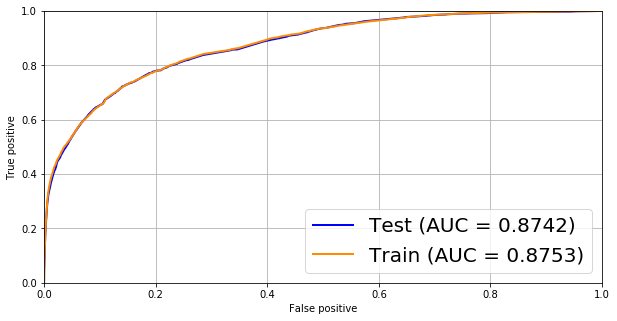

In [75]:
fig = plt.figure(figsize=(10, 5))
plot_roc_curve(y_test, y_test_pred, 'blue', 'Test')
plot_roc_curve(y_train, y_train_pred, 'darkorange', 'Train')

### 3.5. Выведем результаты на кривую Precision-Recall

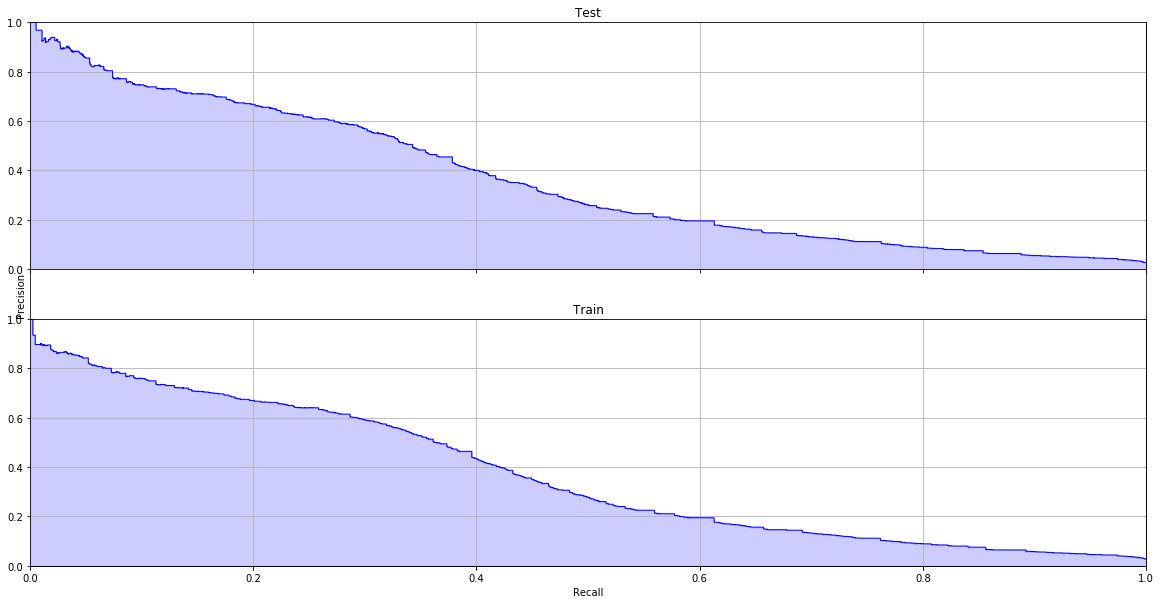

In [83]:
fig = plt.figure(figsize=[20, 10])
ax = plt.axes()
ax.set_yticks([])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plot_precision_recall(fig, y_test, y_test_pred, 'Test', 1, 2)
plot_precision_recall(fig, y_train, y_train_pred, 'Train', 2, 2)

### 3.6. Выведем важность фич

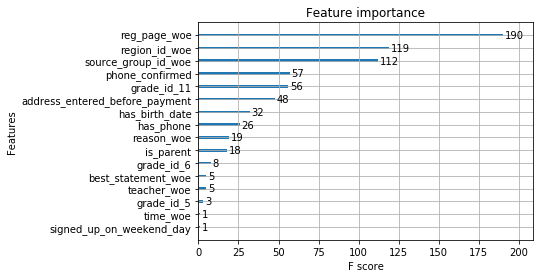

In [92]:
model.plot_importance()

### 3.7. Формирование дерева решений для graphviz
http://www.webgraphviz.com/

In [99]:
print(model.get_tree(4))

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="region_id_woe <= 2.318\ngini = 0.052\nsamples = 838860\nvalue = [816336, 22524]", fillcolor="#e58139f8"] ;
1 [label="region_id_woe <= 2.268\ngini = 0.04\nsamples = 819788\nvalue = [802899, 16889]", fillcolor="#e58139fa"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="address_entered_before_payment <= 0.5\ngini = 0.258\nsamples = 21340\nvalue = [18099, 3241]", fillcolor="#e58139d1"] ;
1 -> 2 ;
3 [label="reg_page_woe <= -2.121\ngini = 0.5\nsamples = 5253\nvalue = [2656, 2597]", fillcolor="#e5813906"] ;
2 -> 3 ;
4 [label="gini = 0.181\nsamples = 308\nvalue = [277, 31]", fillcolor="#e58139e2"] ;
3 -> 4 ;
5 [label="gini = 0.499\nsamples = 4945\nvalue = [2379, 2566]", fillcolor="#399de513"] ;
3 -> 5 ;
6 [label="grade_id_11 <= 0.5\ngini = 0.077\nsamples = 16087\nvalue = [15443, 644]", fillcolor="#e58139f4"] ;
2 -> 6 ;
7 [label="gini = 0.023\nsamples = 8240\nvalue = [8145, 95]", fillcolor="#e5

### 3.8. Промежуточные итоги
Модель показывает устойчивые результаты на всей выборке. Roc-кривая и кривая precision-recall говорят о хорошей вероятности предсказания целевого события. <br>
Наиболее важные признаки для XGBoost: страница регистрации, регион и канал продвижения.<br>
Дерево принятия решений показывает несколько другой список важных признаков. С XGBoost совпали страница регистрации и регион, но в другом порядке.

## Следующие задачи
4. Обучить и сделать предсказания для временного сэмпла
5. Уменьшить интервал трейна для временного интервала настолько насколько получится без последствий для точности
6. Попытаться сделать предсказание отдельно для пользователей, у которых введен телефон и для пользователей, у которых не введен. Сравнить получившиеся предсказания с предсказаниями без разделения.

* ROC-AUC
6. Feature importance
7. Дерево принятия решений
1. Выводить предикт на трейн
2. Кросс-валидация
4. Взять данные за год и смотрим не упадет ликачество модели
5. брать данные за 4 месяца и предсказать 2 недели
8. Порог отсечения
9. Определить имена и фамилии
11. Зафитить только людей, у которых нет телефонов
12. Зафитить только людей, у которых есть телефоны

In [97]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>